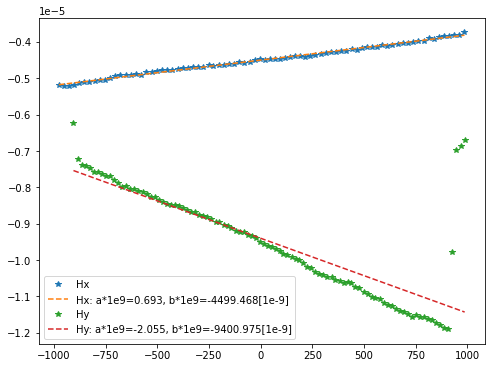

In [1]:
# visualise standard Ry phase
import matplotlib.pyplot as plt 
import pandas as pd 

from scipy.optimize import curve_fit


def linear(x, a, b):
    return a*x + b 

def quadratic(x, a, b):
    return a*(x**2) + b


# linear/quadratic range 
start, stop = -1000, 1000 
src_hy = pd.read_csv("./Ta_CoFeB_harmonics/5360_54_2f_hy.csv")
src_hx = pd.read_csv("./Ta_CoFeB_harmonics/5360_54_2f_hx.csv")

fig, ax = plt.subplots(figsize=(8, 6))

for dt, dt_name in zip([src_hx, src_hy], ['Hx', 'Hy']):
    x_data = dt.iloc[:len(dt)//2].loc[dt[dt_name].between(start, stop), dt_name]
    y_data = dt.iloc[:len(dt)//2].loc[dt[dt_name].between(start, stop), '2f']
    popt, pcov = curve_fit(linear, x_data, y_data)
    a, b = popt
    ax.plot(x_data, y_data, '*', label=f'{dt_name}')
    ax.plot(x_data, linear(x_data, *popt), '--',
            label=f'{dt_name}: {a*1e9=:.3f}, {b*1e9=:.3f}[1e-9]')
ax.legend()

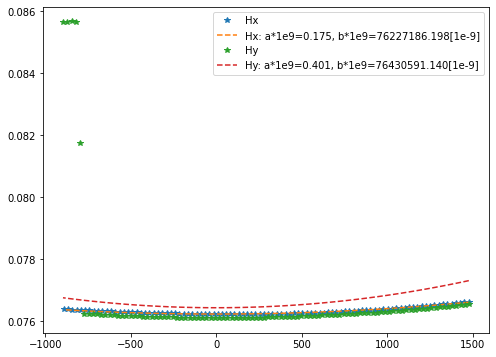

In [2]:
src_hy = pd.read_csv("./Ta_CoFeB_harmonics/5360_54_1f_hy.csv")
src_hx = pd.read_csv("./Ta_CoFeB_harmonics/5360_54_1f_hx.csv")

fig, ax = plt.subplots(figsize=(8, 6))
start, stop = -900, 1500 
for dt, dt_name in zip([src_hx, src_hy], ['Hx', 'Hy']):
    x_data = dt.iloc[len(dt)//2:].loc[dt[dt_name].between(start, stop), dt_name]
    y_data = dt.iloc[len(dt)//2:].loc[dt[dt_name].between(start, stop), '1f']
    popt, pcov = curve_fit(quadratic, x_data, y_data)
    a, b = popt
    ax.plot(x_data, y_data, '*', label=f'{dt_name}')
    ax.plot(x_data, quadratic(x_data, *popt), '--',
            label=f'{dt_name}: {a*1e9=:.3f}, {b*1e9=:.3f}[1e-9]')
ax.legend()

In [3]:
p = 1/7.34e-2 # PHE to AHE

def torque(zeta, Bl, Bt, p):
    r = -2/zeta 
    fr = (Bl + 2*p*Bt)/(1-4*(p**2))
    return r*fr 

# x - long. y - transver. 
Bl = 0.693e-9 * (-1) # -Mz
Bt = -2.055e-9  * (-1) # -Mz
zeta = 2*0.175e-9 # 2nd derivative 

Hdl = torque(zeta, Bl, Bt, p)
Hfl = torque(zeta, Bt, Bl, p)
print(f"{Hdl=}, {Hfl=}")

Hdl=0.426203221599998, Hfl=-0.12969034176728006


In [1]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import Output, VBox
import numpy as np
from scipy.fft import fft, fftshift
from scipy.signal.windows import hann
from scipy.signal import correlate
from typing import List
from cmtj.utils.linear import FieldScan
from cmtj.utils.filters import Filters
from collections import defaultdict
from tqdm.notebook import tqdm
from numpy.fft import fftfreq
import cmtj

def compute_vsd(frequency, dynamicR, integration_step, dynamicI):
    SD = -dynamicI*dynamicR
    fs = 1.0 / integration_step
    SD_dc = Filters.butter_lowpass_filter(SD, cutoff=10e6, fs=fs, order=3)
    SD_fft_org = fft(SD)
    SD_fft = SD_fft_org[:len(SD) // 2]
    freqs_org = fftfreq(len(SD), integration_step)
    freqs = freqs_org[:len(SD) // 2]
    amplitude = np.abs(SD_fft)
    phase = np.angle(SD_fft)
    # first harmonic
    # argmax in range frequency
    # delete phase that's close to 0 
    # eps = 0.01 
    # phase[np.abs(amplitude) <= eps] = 0 

    fhar_index = np.argmin(np.abs(freqs-frequency))
    # second harmonic
    # argmax in range 2*frequency
    shar_index = np.argmin(np.abs(freqs - 2 * frequency))


    fhar_index = np.argsort(np.abs(freqs - frequency))[:5]  # neighbourhood
    max_fhar_amp_indx = np.argmax(SD_fft[fhar_index])
    # second harmonic
    # argmax in range 2*frequency
    shar_index = np.argsort(np.abs(freqs - 2*frequency))[:5]  # neighbourhood
    max_shar_amp_indx = np.argmax(SD_fft[shar_index])

    SD_fft_org = fftshift(SD_fft_org)
    freqs_org = fftshift(freqs_org)

    org_phase = np.angle(SD_fft_org)
    org_amp = np.abs(SD_fft_org)
    # org_phase[np.abs(org_amp) <= eps] = 0

    return np.mean(SD_dc), amplitude[fhar_index][max_fhar_amp_indx], amplitude[shar_index][max_shar_amp_indx], phase[
        fhar_index][max_fhar_amp_indx], phase[shar_index][max_shar_amp_indx], org_amp, org_phase, freqs_org


def calculate_resistance(Rx0, Ry0, AMR, AHE, SMR, m, number_of_layers, l, w):
    R_P = Rx0[0]
    R_AP = Ry0[0]

    if m.ndim == 2:
        SxAll = np.zeros((number_of_layers, ))
        SyAll = np.zeros((number_of_layers, ))

    elif m.ndim == 3:
        SxAll = np.zeros((number_of_layers, m.shape[2]))
        SyAll = np.zeros((number_of_layers, m.shape[2]))

    for i in range(0, number_of_layers):
        w_l = w[i] / l[i]
        SxAll[i] = 1 / (Rx0[i] + (AMR[i] * m[i, 0]**2 + SMR[i] * m[i, 1]**2))
        SyAll[i] = 1 / (Ry0[i] + 0.5 * AHE[i] * m[i, 2] + (w_l) *
                        (SMR[i] - AMR[i]) * m[i, 0] * m[i, 1])

    Rx = 1 / np.sum(SxAll, axis=0)
    Ry = 1 / np.sum(SyAll, axis=0)

    if number_of_layers > 1:
        Rz = R_P + ((R_AP - R_P) / 2) * (1 - np.sum(m[0, :] * m[1, :], axis=0))
    else:
        Rz = 0

    return Rx, Ry, Rz


    thickness = 1.15e-9
layer_params = {
    "Ms": 0.5,
    "thickness": thickness,
    "anis": cmtj.CVector(0, 0, 1.),
    "mag": cmtj.CVector(0, 0, 1.),
    "cellSurface": 1.0,
    "demagTensor": demag,
    "dipoleTensor": dipole,
    "damping": 0.03,
    "fieldLikeTorque": 0.426203221599998,
    "dampingLikeTorque": -0.12969034176728006
}

In [19]:
Hscan, Hvecs = FieldScan.amplitude_scan(-800e3, 800e3, 30, 90, 0)
# Hscan, Hvecs = FieldScan.phi_scan(-180, 180, 30, 800e3, 90)
s_time = 8e-9
int_step = 1e-12

dipole = [cmtj.CVector(0, 0, 0), cmtj.CVector(0, 0, 0), cmtj.CVector(0, 0, 0)]
demag = [cmtj.CVector(0, 0, 0), cmtj.CVector(0, 0, 0), cmtj.CVector(0, 0, 1)]

thickness = 1.e-9
l1_params = {
    "Ms": 0.5,
    "thickness": thickness,
    "anis": cmtj.CVector(0, 0, 1.),
    "mag": cmtj.CVector(0, 0, 1.),
    "cellSurface": 1.0,
    "demagTensor": demag,
    "dipoleTensor": dipole,
    "damping": 0.03,
    "fieldLikeTorque": 0.426203221599998,
    "dampingLikeTorque": -0.12969034176728006
}

l1 = cmtj.Layer.createSOTLayer(id="free", **l1_params)
layer_str = ["free"]
layers = [l1]
junction = cmtj.Junction(layers=layers)
junction.setLayerAnisotropyDriver("all", cmtj.ScalarDriver.getConstantDriver(1.7e5))

freq_scan = np.linspace(0e9, 0.01e9, num=20)

mags = [cmtj.CVector(*Hvecs[0]) for _ in layer_str]
I_rf = 1
I_dc = 0
I_dir = [1, 0, 0]

Rx0 = [100]
Ry0 = [120]
AMR = [-0.02]
SMR = [-.25]
AHE = [-2.3]
l = [3e-5]
w = [2e-5]
area = thickness * w[0]
data = defaultdict(lambda: np.zeros((len(Hvecs), len(freq_scan))))

steps = int(s_time / int_step)
data2 = defaultdict(lambda: np.zeros((len(Hvecs), len(freq_scan), steps)))
Hoe = 1.25e4

for hi, Hval in tqdm(enumerate(Hvecs), total=len(Hvecs)):
    # set external field globally
    HDriver = cmtj.AxialDriver(cmtj.ScalarDriver.getConstantDriver(Hval[0]),
                               cmtj.ScalarDriver.getConstantDriver(Hval[1]),
                               cmtj.ScalarDriver.getConstantDriver(Hval[2]))
    junction.setLayerExternalFieldDriver("all", HDriver)

    for fi, frequency in enumerate(freq_scan):
        junction.clearLog()
        # set magnetisation for better convergence
        for i, l_str in enumerate(layer_str):
            junction.setLayerMagnetisation(l_str, mags[i])

        driver = cmtj.AxialDriver(
            cmtj.NullDriver(),
            cmtj.ScalarDriver.getSineDriver(Hoe * I_dc, Hoe * I_rf, frequency,
                                            0), cmtj.NullDriver())
        # set Oersted and current drivers
        junction.setLayerOerstedFieldDriver("all", driver)
        junction.runSimulation(s_time, int_step, int_step)
        for i in range(len(layers)):
            mags[i] = junction.getLayerMagnetisation(layer_str[i])

        log = junction.getLog()
        m = np.asarray([[
            log[f'{layer_str[i]}_mx'], log[f'{layer_str[i]}_my'],
            log[f'{layer_str[i]}_mz']
        ] for i in range(len(layers))])

        dynamicRx, dynamicRy, _ = calculate_resistance(Rx0, Ry0, AMR, AHE, SMR,
                                                       m, len(layers), l, w)

        lt = np.asarray(log['time'])
        dynamicI = I_dc + I_rf * \
            np.sin(2 * np.pi * frequency * lt)
        Rxdc, _, _, Rxsecond_amp, Rxsecond_phase, a, phase, freqs = compute_vsd(
            dynamicR=dynamicRx,
            frequency=frequency,
            integration_step=int_step,
            dynamicI=dynamicI)

        data['Rx_2nd_phase'][hi, fi] = Rxsecond_phase
        data['Rx_2nd_amplitude'][hi, fi] = Rxsecond_amp
        data['Rx_dc'][hi, fi] = Rxdc
        data2['Rx_resistance'][hi, fi, :] = dynamicRx
        data2['Rx_mixing'][hi, fi, :] = dynamicRx * dynamicI
        data2['Rx_fft'][hi, fi, :] = a
        data2['Ry_fft_phase'][hi, fi, :] = phase
        data2['Ry_ftt_freqs'][hi, fi, :] = freqs

        Rydc, Ryfirst_amp, Ryfirst_phase, Rysecond_amp, Rysecond_phase, a, phase, freqs = compute_vsd(
            dynamicR=dynamicRy,
            frequency=frequency,
            integration_step=int_step,
            dynamicI=dynamicI)

        data['Ry_1st_phase'][hi, fi] = Ryfirst_phase
        data['Ry_1st_amplitude'][hi, fi] = Ryfirst_amp

        data['Ry_2nd_phase'][hi, fi] = Rysecond_phase
        data['Ry_2nd_amplitude'][hi, fi] = Rysecond_amp
        data['Ry_dc'][hi, fi] = Rydc
        data2['Ry_resistance'][hi, fi, :] = dynamicRy
        data2['Ry_mixing'][hi, fi, :] = dynamicRy * dynamicI
        data2['Ry_fft_phase'][hi, fi, :] = a
        data2['Ry_fft'][hi, fi, :] = phase
        data2['Ry_ftt_freqs'][hi, fi, :] = freqs

  0%|          | 0/30 [00:00<?, ?it/s]

In [21]:
fig = go.FigureWidget(make_subplots(rows=2, cols=2))
fig.layout.hovermode = 'closest'


def normalise(x):
    return x/np.linalg.norm(x, axis=0)

r = 'Ry'
res_0 = data2[f'{r}_resistance'][0, 0]
mix_0 = data2[f'{r}_mixing'][0, 0]
fft_0 = data2[f'{r}_fft'][0, 0]
tx = np.arange(len(res_0))
# h1 = go.Heatmap(z=normalise(data[f'{r}_dc']).T)
h1 = go.Heatmap(z=data[f'{r}_1st_amplitude'].T)
s3 = go.Scatter(x=tx, y=fft_0)
s1 = go.Scatter(x=tx, y=res_0)
s2 = go.Scatter(x=tx, y=mix_0)

out = Output()


@out.capture(clear_output=True)
def update_graph(trace, points, selector):
    if not points.xs:
        return
    x = points.xs[0]
    y = points.ys[0]

    fig.data[1].y = data2[f'{r}_resistance'][x, y, :]
    fig.data[2].y = data2[f'{r}_mixing'][x, y, :]
    # fig.data[3].y = data2[f'{r}_fft_phase'][x, y, :]
    fig.data[3].y = data[f'{r}_1st_amplitude'][:, y]
    # fig.data[3].y = data[f'{r}_2nd_phase'][:, y]
    # fig.data[3].x = data2[f'{r}_ftt_freqs'][x, y, :]

fig.add_trace(h1, row=1, col=1)
fig.add_trace(s1, row=1, col=2)
fig.add_trace(s2, row=2, col=2)
fig.add_trace(s3, row=2, col=1)
fig.data[0].on_click(update_graph)

fig.update_layout(height=800, width=800)
fig['layout']['xaxis1'].update(title_text='H [A/m]')
fig['layout']['yaxis1'].update(title_text='Frequency [GHz]')
fig['layout'][f'xaxis2'].update(title_text='Resistance')
fig['layout'][f'xaxis3'].update(title_text='FFT amp')
fig['layout'][f'xaxis4'].update(title_text='Mixing amp')
VBox([fig, out])

    'data': [{'type': 'heatmap',
              'uid': '9d12fc17-bf39-4352-b279-6…